In [1]:
import os
import sys

sys.path.append("../../")
import pickle

import numpy as np
import pyaldata as pyal

from tools.dimensionality.participation import get_pr_for_subsets_of_neurons, isomap_pr
from tools.dsp.preprocessing import preprocess
from tools.params import Params

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [133]:
# --- Load input video ---
folder_path = '/data/bnd-data/raw/M062/M062_2025_03_21_14_00/M062_2025_03_21_14_00_cameras/'
video_path = 'Camera_0.avi'

results_path = "/home/me24/repos/earthquake-analysis/results/"

start_frame = 48000
end_frame = 50599 # 50599  # Exclusive


perturbation1 = [48300, 48300 + 5]
perturbation2 = [49200, 49200 + 20]
perturbation3 = [49900, 49900 + 15]


# --- Video parameters ---
output_path = results_path + 'output.avi'

# Open input video
cap = cv2.VideoCapture(folder_path + video_path)
if not cap.isOpened():
    raise IOError("Error opening video file.")

# Video properties
# fps = cap.get(cv2.CAP_PROP_FPS)
fps = 100
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Or 'mp4v' for mp4 output

# Create output video writer
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Set starting frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Process frames 100 to 200
for frame_idx in range(start_frame, end_frame):
    ret, frame = cap.read()
    if not ret:
        break  # Stop if video ends early

    # Dot position: top-right corner (10px margin)
    dot_pos = (width - 60, 60)

    # Determine dot colour
    # if frame_idx == 5:
    if (
        (frame_idx > perturbation1[0]) and (frame_idx < perturbation1[-1]) or 
        (frame_idx > perturbation2[0]) and (frame_idx < perturbation2[-1]) or 
        (frame_idx > perturbation3[0]) and (frame_idx < perturbation3[-1])
        ):
        colour = (0, 255, 0)  # Green
    else:
        colour = (0, 0, 255)  # Red

    # Draw dot
    cv2.circle(frame, dot_pos, radius=50, color=colour, thickness=-1)

    # Write frame to output video
    out.write(frame)

    frame_idx += 1

# Cleanup
cap.release()
out.release()

print(f"Saved 10-frame video with dot overlays to: {output_path}")


!ffmpeg -i ../../results/output.avi -c:v libx264 -crf 23 ../../results/output.mp4 -y
!rm -f ../../results/output.avi

Saved 10-frame video with dot overlays to: /home/me24/repos/earthquake-analysis/results/output.avi
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh -

In [2]:
data_dir = "/data/bnd-data/raw/"
session = 'M062_2025_03_21_14_00'

df = pyal.load_pyaldata(data_dir + session[:4] + '/' + session)
# df = preprocess(df, only_trials=False)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted to int.
field idx_Sol_direction could not be converted to int.
field values_Sol_duration could not be converted to int.
field idx_Sol_duration could not be converted to int.
field idx_sol_on could not be converted to int.
array field all_KSLabel could not be converted to int.
array field SSp_KSLabel could not be converted to int.
array field VAL_KSLabel could not be converted to int.
array field CP_KSLabel could not be converted to int.
array field MOp_KSLabel could not be converted to int.
field values_Sol_direction could not be converted t

In [14]:
angles = []
for col in df.columns:
    if col.endswith("angle"):
        angles.append(np.concatenate(df[f'{col}'].values))
angles = np.array(angles)

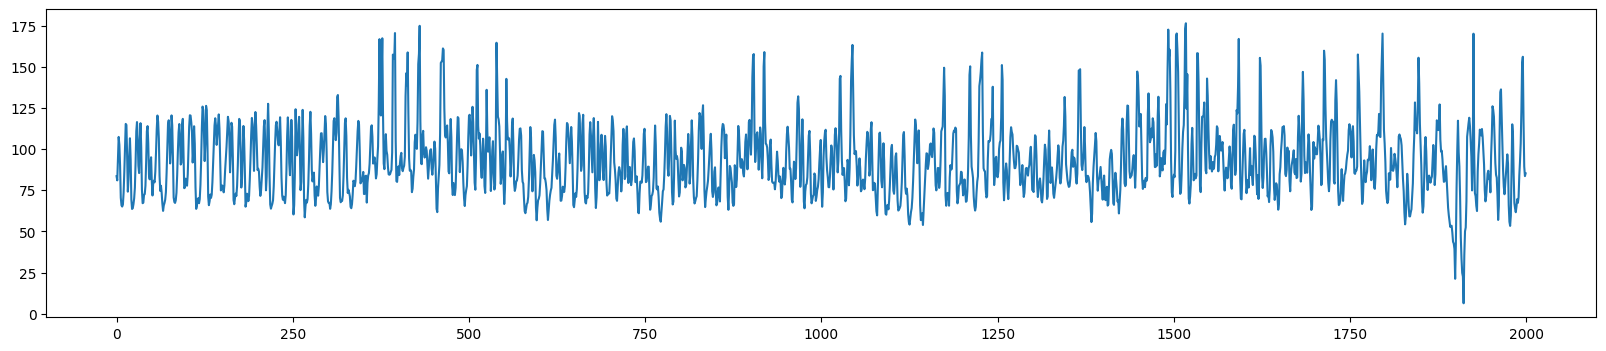

In [23]:
plt.figure(figsize=(20, 4))
plt.plot(angles[0, start_frame:end_frame])
plt.show()

In [3]:
inter_trials_df = pyal.select_trials(df, df.trial_name != 'free')

In [4]:
angles = []
cols = []
for col in inter_trials_df.columns:
    if col.endswith("angle"):
        angles.append(np.concatenate(inter_trials_df[f'{col}'].values[:7]))
        cols.append(col)
angles = np.array(angles)

In [5]:
angles.shape

(8, 2600)

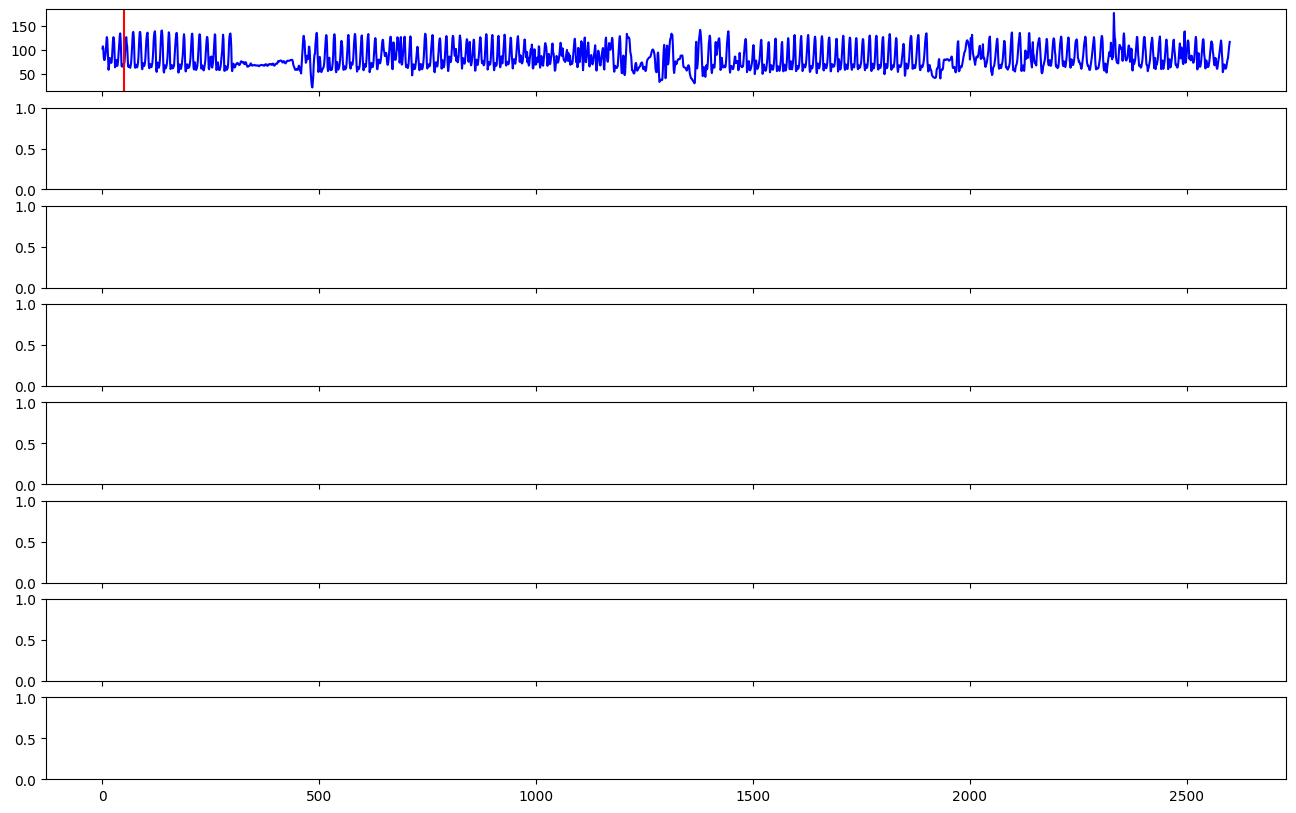

In [119]:
fig, axes = plt.subplots(8, figsize=(16, 10), sharex='all')

axes[0].plot(angles[0, :], 'b-', label='Signal')
axes[0].axvline(x=50, color='r')
# plt.plot(time, angles[1, :], 'b-', label='Signal')
# plt.plot(time, angles[3, :], 'b-', label='Signal')

plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

# Generate synthetic time-series data
time = np.arange(0, 26, 0.01)
data = angles[:, :] 

start_frame = 48000
end_frame = 50599 # 50599  # Exclusive


perturbation1 = [48300, 48300 + 5]
perturbation2 = [49200, 49200 + 20]
perturbation3 = [49900, 49900 + 15]


# Create a temporary directory to store the frames
os.makedirs('frames', exist_ok=True)

# Generate and save frames
for i in tqdm(range(len(time))):
    fig, axes = plt.subplots(data.shape[0], figsize=(16, 10), sharex='all')
    for index, ax, col in zip(range(8), axes, cols):
        ax.plot(time[:i+1], data[index, :i+1], 'b-', linewidth=2)
        if i > (perturbation1[0]-start_frame)*0.01:
            ax.axvline((perturbation1[0]-start_frame)*0.01, color='r', linewidth=1.5, linestyle='dashed')
        if i > (perturbation2[0]-start_frame)*0.01:
            ax.axvline((perturbation2[0]-start_frame)*0.01, color='r', linewidth=1.5, linestyle='dashed')
        if i > (perturbation2[0]-start_frame)*0.01:
            ax.axvline((perturbation3[0]-start_frame)*0.01, color='r', linewidth=2, linestyle='dashed')
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # Remove axes edges
        for spine in ax.spines.values():
            spine.set_visible(False)

    

    ax.set_xlim(time[0], time[-1])
    plt.xlabel('Time')
    plt.tight_layout()
    plt.savefig(f'frames/frame_{i:03d}.png')
    plt.close()

# Create video
frame_rate = 100  # frames per second
frame = cv2.imread('frames/frame_000.png')
height, width, layers = frame.shape
video = cv2.VideoWriter('timeseries_video.avi', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width, height))

for i in range(len(time)):
    frame = cv2.imread(f'frames/frame_{i:03d}.png')
    video.write(frame)

video.release()

# Clean up frames directory (optional)
import shutil
shutil.rmtree('frames')

print("Video saved as 'timeseries_video.avi'.")
!ffmpeg -i timeseries_video.avi -c:v libx264 -crf 23 timeseries_video.mp4 -y


  0%|          | 0/2600 [00:00<?, ?it/s]

100%|██████████| 2600/2600 [12:40<00:00,  3.42it/s]  


Video saved as 'timeseries_video.avi'.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --

In [128]:
(perturbation1[0]-start_frame) * 0.01

3.0

  0%|          | 0/2600 [00:00<?, ?it/s]

  5%|▍         | 123/2600 [00:12<04:03, 10.17it/s]


KeyboardInterrupt: 

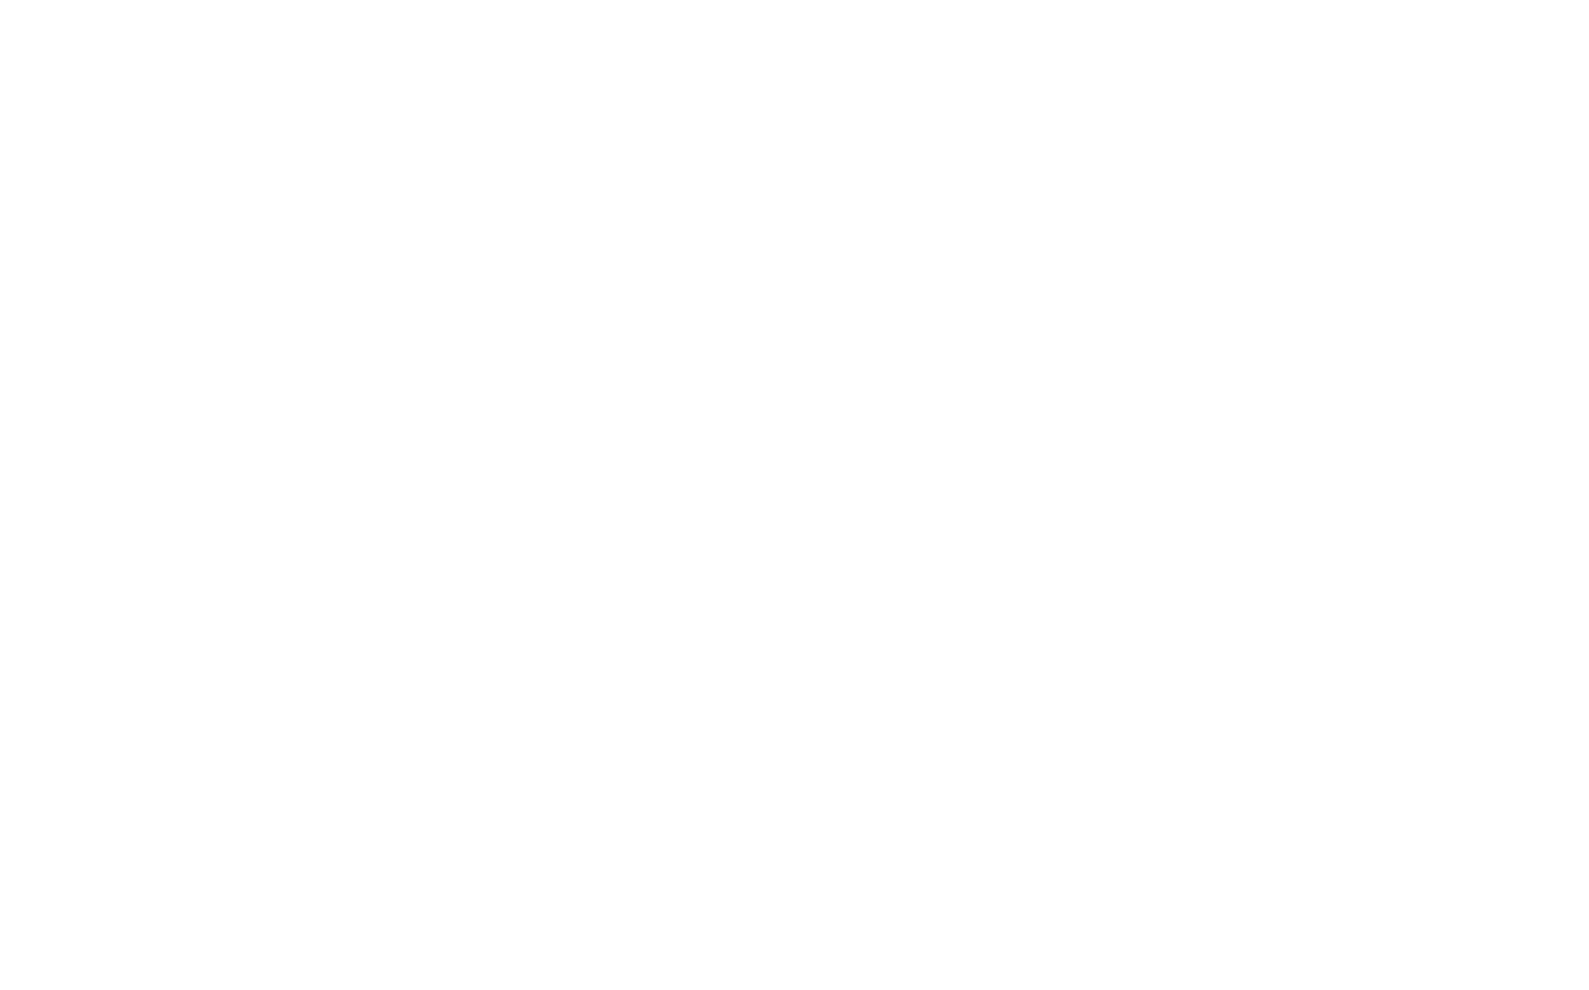

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

start_frame = 48000
end_frame = 50599 # 50599  # Exclusive


perturbation1 = [48300, 48300 + 5]
perturbation2 = [49200, 49200 + 20]
perturbation3 = [49900, 49900 + 15]


# Example data
time = np.arange(0, 26, 0.01)
data = angles

# Create figure and axes only once
fig, axes = plt.subplots(data.shape[0], figsize=(16, 10), sharex=True)

lines = []
for ax in axes:
    line, = ax.plot([], [], 'b-', linewidth=2)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    lines.append(line)

# Set axis limits only once
axes[-1].set_xlim(time[0], time[-1])

# Create a temporary directory to store the frames
os.makedirs('frames', exist_ok=True)

# Update the lines instead of re-creating plots
for i in tqdm(range(len(time))):
    for idx, line in enumerate(lines):
        line.set_data(time[:i+1], data[idx, :i+1])

    plt.tight_layout()
    fig.savefig(f'frames/frame_{i:03d}.png')

plt.close()

# Create video
frame_rate = 100  # frames per second
frame = cv2.imread('frames/frame_000.png')
height, width, _ = frame.shape
video = cv2.VideoWriter('timeseries_video.avi', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width, height))

for i in range(len(time)):
    frame = cv2.imread(f'frames/frame_{i:03d}.png')
    video.write(frame)

video.release()

# Clean up frames directory
import shutil
shutil.rmtree('frames')

print("Video saved as 'timeseries_video.avi'.")

# Use ffmpeg for compression
!ffmpeg -i timeseries_video.avi -c:v libx264 -crf 23 timeseries_video.mp4 -y


In [100]:
inter_trials_df[:7].idx_trial_start

0    48000
1    48100
2    48700
3    49000
4    49600
5    49700
6    50300
Name: idx_trial_start, dtype: int32

In [101]:
inter_trials_df[:7].values_Sol_duration

0     []
1     50
2     []
3    200
4     []
5    150
6     []
Name: values_Sol_duration, dtype: object

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,VAL_KSLabel,VAL_spikes,CP_chan_best,CP_unit_guide,CP_KSLabel,CP_spikes,MOp_chan_best,MOp_unit_guide,MOp_KSLabel,MOp_spikes
0,M062,M062_2025_03_21_14_00,1,intertrial,100,0.01,48000,48099,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,M062,M062_2025_03_21_14_00,2,trial,600,0.01,48100,48699,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,M062,M062_2025_03_21_14_00,3,intertrial,300,0.01,48700,48999,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,M062,M062_2025_03_21_14_00,4,trial,600,0.01,49000,49599,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,M062,M062_2025_03_21_14_00,5,intertrial,100,0.01,49600,49699,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,M062,M062_2025_03_21_14_00,6,trial,600,0.01,49700,50299,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5, 5, 5, ...","[[0, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5...","[good, good, good, good, good, good, good, goo...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[250, 250, 251, 251, 252, 252, 252, 252, 252, ...","[[250, 1], [250, 2], [251, 1], [251, 2], [252,...","[good, good, good, good, good, mua, good, mua,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,M062,M062_2025_03_21_14_00,7,intertrial,300,0.01,50300,50599,[],[],...,"[mua, mua, mua, mua, good, good, mua, mua, goo...","[[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 1, 1, 1, 1, 1, 1, 1, 2,